# Fast Fourier Transform test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_earthquake_data(excel_file):
    # read the data
    df = pd.read_excel(excel_file, usecols=[0, 1], header=None)

    # get the data
    time_data = df[0].tolist()  # time
    earthquake_data = df[1].tolist()  # data

    print(len(time_data))

    # plot the data
    plt.figure(figsize=(15, 5))
    plt.plot(time_data, earthquake_data, marker='o', linestyle='-')
    plt.title('Acceleration over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

4001


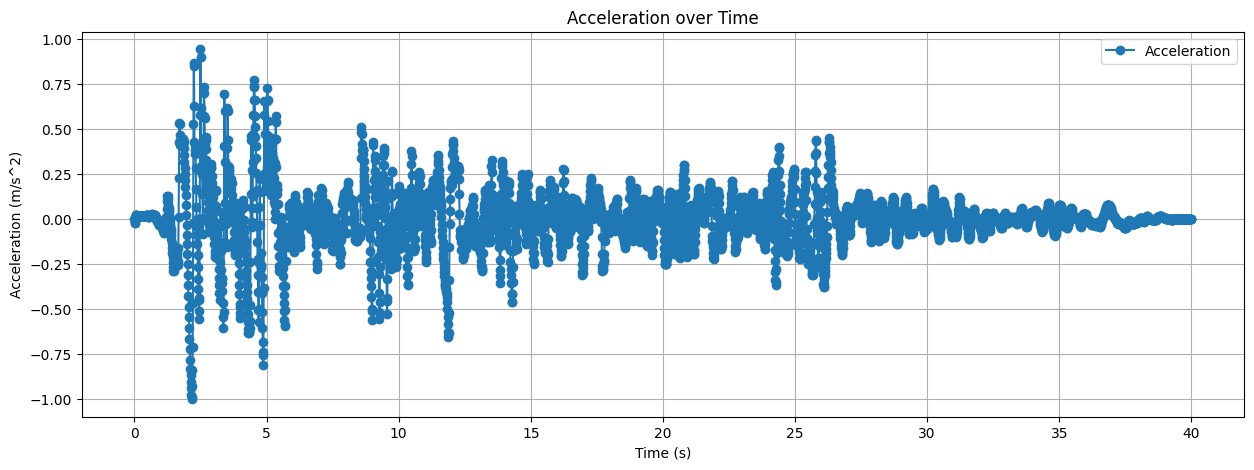

In [2]:
import os

# Excel Path
gm_data = 'El-Centro.xlsx'
file_path = os.path.join("Data", "GM_Example", gm_data)

# Plot
plot_earthquake_data(file_path)

In [3]:
import pandas as pd
import torch

# raad the excel file
df = pd.read_excel(file_path, usecols=[1], header=None)  # 仅读取data列

# cut the last of the data [4001] --> [4000]
data_without_last = df.iloc[:-1, 0]

# [4000] --> [2000]
resampled_data = data_without_last.iloc[::2].tolist()

assert len(resampled_data) == 2000, "Length resampled_data ({resample_data} is not equal 2,000)"

# padding 0 to the data
# padded_data = resampled_data + [0] * 1000
# padded_data = [0] * 1000 + resampled_data 
padded_data = [0] * 500 + resampled_data + [0] * 500

# Tensor[1, 3000, 1]
data_tensor = torch.tensor(padded_data, dtype=torch.float).view(1, -1, 1)

data_tensor.shape  # torch.Size([1, 3000, 1]),  = (3000, 1)

torch.Size([1, 3000, 1])

In [4]:
import numpy as np
gm_np_padded = np.array(padded_data)

gm_np_padded.shape, gm_np_padded.shape[0]

((3000,), 3000)

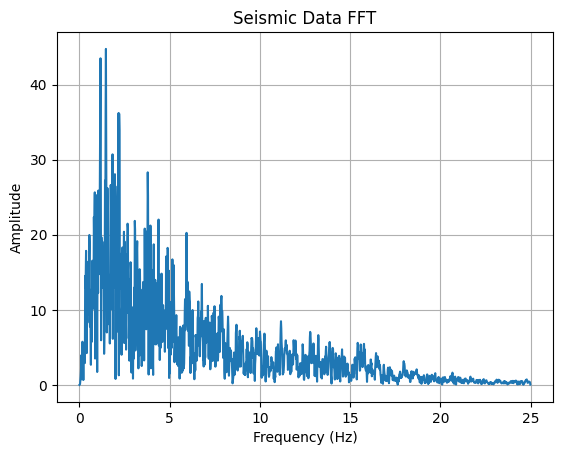

In [5]:

import matplotlib.pyplot as plt

# 假设你的地震动数据存储在一个名为seismic_data的列表或者numpy数组里
# 这里我们将创建一个模拟的地震动数据作为例子
duration = 60  # 持续时间（秒）
n_points = gm_np_padded.shape[0]   # 数据点数

# 生成一个模拟的地震动数据
# 例如：生成一个简单的正弦波，振幅随机变化
t = np.linspace(0, duration, n_points)  # 时间向量
seismic_data = gm_np_padded

# 执行FFT
fft_seismic_data = np.fft.fft(seismic_data)

# 频率分辨率
delta_t = duration / n_points
frequencies = np.fft.fftfreq(n_points, delta_t)

# 绘制频谱
plt.figure()
plt.plot(frequencies[:n_points // 2], np.abs(fft_seismic_data)[:n_points // 2])  # 只绘制正频率部分
# plt.plot(frequencies, np.abs(fft_seismic_data))  # 只绘制正值部分
# plt.plot(frequencies, fft_seismic_data)  # 全绘制
plt.title('Seismic Data FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [6]:
import torch
import torch.nn as nn

# 定义卷积层，这次使用计算出的kernel_size和stride
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=36, stride=2, padding=0)



Output Length: 733


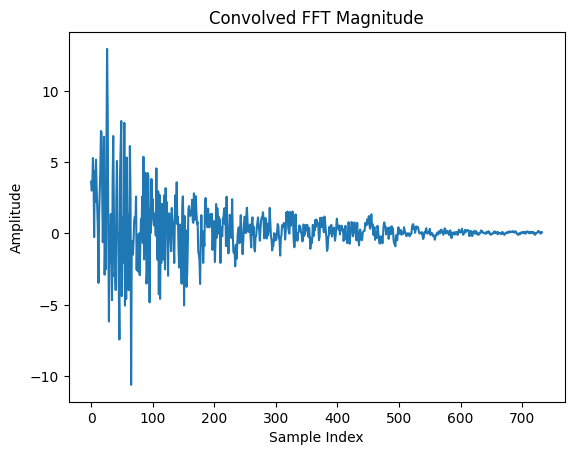

In [7]:
import torch.nn as nn

fft_seismic_data = np.fft.fft(seismic_data)

# 提取幅值
fft_magnitude = np.abs(fft_seismic_data[:n_points // 2])

# 转换为PyTorch张量
fft_magnitude_torch = torch.tensor(fft_magnitude, dtype=torch.float32)

# 调整维度以匹配PyTorch期望的输入 (batch_size, channels, length)
fft_magnitude_torch = fft_magnitude_torch.unsqueeze(0).unsqueeze(0)

# 应用卷积
convolved = conv(fft_magnitude_torch)

# 检查输出尺寸
output_length = convolved.shape[-1]
print(f'Output Length: {output_length}')

# 可视化
convolved_np = convolved.detach().squeeze().numpy()
plt.plot(convolved_np)
plt.title('Convolved FFT Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


In [8]:
from PythonScripts.data_preparation import LoadData, H5pyToTensor, CreateDataLoader, CreateDataLoadersWithMultiDataset, MaskingData, TransformMaskData
DATA_SOURCE = "50Hz_60s"

file_name = "cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat"
traindata_path, valdata_path, testdata_path = LoadData(time_series=DATA_SOURCE,
                                                       file_name=file_name)
train_data, train_labels, validation_data, validation_labels, test_data, test_labels = H5pyToTensor(traindata_path=traindata_path,
                                                                                                    valdata_path=valdata_path,
                                                                                                    testdata_path=testdata_path,
                                                                                                    transpose=True)


traindata_path: Data\50Hz_60s\train\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat
valdata_path: Data\50Hz_60s\validation\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat
testdata_path: Data\50Hz_60s\test\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat


In [9]:

import numpy as np

def to_frequency_domain(time_domain_data):
    # 对每一行数据执行FFT变换
    freq_domain_data = np.fft.rfft(time_domain_data)

    # FFT的输出是复数，取其绝对值可以得到幅度信息
    # 我们只保留前1500个分量，因为剩余的是对称的
    freq_domain_data = np.abs(freq_domain_data[:, :1500])

    return freq_domain_data

In [10]:
freq_domain_signals = to_frequency_domain(train_data)

freq_domain_signals.shape

(60940, 1500)

In [11]:
len(freq_domain_signals[0])

1500

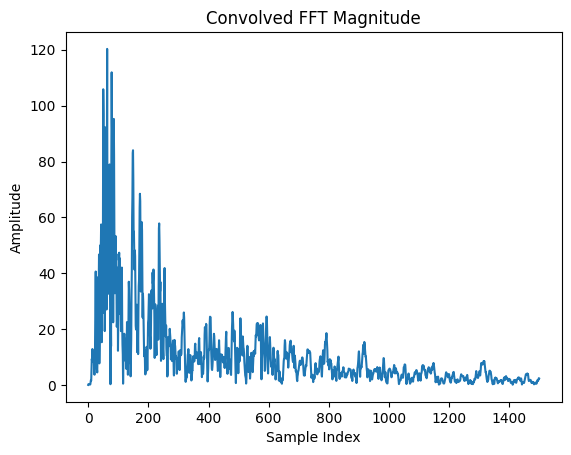

In [27]:
import matplotlib.pyplot as plt

plt.plot(freq_domain_signals[1])
plt.title('Convolved FFT Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

In [42]:
import torch
import torch.nn as nn

# 假设你已经有了一个尺寸为 [60940, 1500] 的 tensor
input_data = torch.tensor(freq_domain_signals)

# 为了使用 PyTorch 的 1D pooling layers，我们需要添加一个维度
# 因为 PyTorch 期望数据的形状为 (batch_size, channels, length)
# 在这个例子中，我们将数据视为 "批量大小" 为 60940 的 "单通道" 数据
input_data = input_data.unsqueeze(1)  # Now shape is [60940, 1, 1500]

# 1D 池化层
# 使用最大池化或者平均池化，这里我们以最大池化为例
pool = nn.MaxPool1d(kernel_size=2, stride=2)


# 应用池化层
output_data = pool(input_data)

# 输出结果
print(output_data.shape)  # 期望输出: torch.Size([60940, 1, 768])

torch.Size([60940, 1, 750])


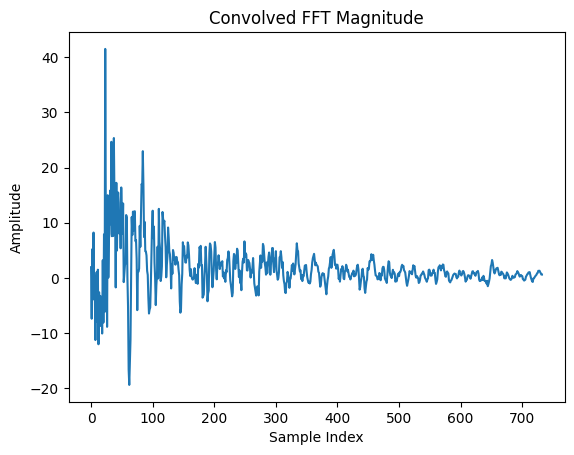

In [32]:
plt.plot(conv1d_embedding[1].detach().numpy())
plt.title('Convolved FFT Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()